In [1]:
import json
import numpy as np
import cv2
from scipy.optimize import minimize

from objective import Cam2Sensor

calibration_file = '/home/hussain/calib_ws/src/aric-camera-calibration/calibration_data/long sensor/calibration_results.json'  # Change this to your calibration file
with open(calibration_file) as f:
    data = json.load(f)

camera_matrix = np.array(data['camera_matrix'])
dist_coeffs = np.array(data['distortion_coeffs'])  # If you have distortion coefficients, replace zeros with the actual values

# flat sensor gelsight
# markers_T_sensor = np.zeros((7,9,3))
# x_m = np.linspace(0,8*1.5,9)
# y_m = np.linspace(0,6*1.5,7)
# z_m = np.zeros((1, 1))



In [2]:
import matplotlib.pyplot as plt
def rtpairs(r, n):        # Distribute the markers on a circle
    for i in range(len(r)):
       for j in range(n[i]):    
        yield r[i], j*(2 * np.pi / n[i])


N =  [1, 6, 12, 18, 24, 30, 36, 42]    # of markers
Dia =  [0.0,  5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0]   # Markers' circular pattern Diamters

S = [ 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]#[ 1, 1, 1, 1, 1, 1, 1]       # Markers' radius (markers' size)
H = 20    # Sensor Height
B = 40.0     # Sensor Base Diamter
T = 4      # Sensor thickness
R = []    # Markers radii

for i in Dia:
    R.append(i/2)    # Markers radii  = Dia / 2

b = B /2       # Sensor Base radius
h=(-b**2+H**2)/(2*H)


Plane_Height = []      
for r in R[1:]:
    z =  ((H-h)**2-r**2)**0.5 + h
    Plane_Height.append((z))

markers_list = []      
for r, t in rtpairs(R, N):
    x =  r * np.cos(t)/1000
    y =  r * np.sin(t)/1000
    z =  (((H-h)**2-r**2)**0.5 + h )/1000
    s = S[R.index(r)]/10000  # sensor size 
    
    markers_list.append((x,y,z))

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X')
# ax.set_ylabel('Z')
# ax.set_zlabel('Y')

# for i in markers_list:
#     ax.scatter(i[0], i[1], i[2], c='r', marker='o')

# plt.show()
    
markers_T_sensor = np.array(markers_list)
markers_T_sensor.shape

(169, 3)

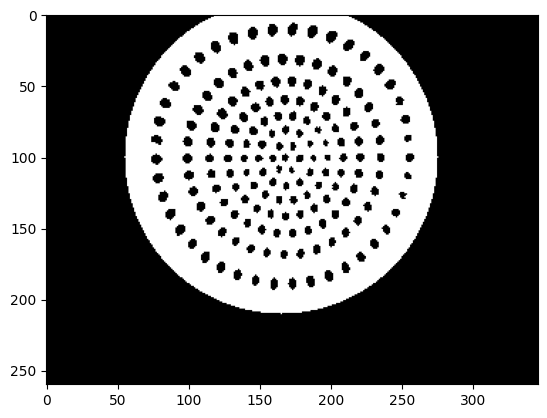

In [3]:
import matplotlib.pyplot as plt

# expermental markers
center = [165, 100] #(162, 123)
roi_r = 110
frame = cv2.imread('image.png')
frame = cv2.undistort(frame, camera_matrix, dist_coeffs)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# roi around center by masking

mask = np.zeros(gray.shape, dtype=np.uint8)
cv2.circle(mask, (center[0], center[1]), roi_r, 255, -1)
masked = cv2.bitwise_and(gray, gray, mask=mask)
gray = masked

#increase contrast clahe
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
con = clahe.apply(gray)

ret, thresh = cv2.threshold(con, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, k3, iterations=1)
thresh = cv2.erode(thresh, k3, iterations=1)
thresh = cv2.dilate(thresh, k3, iterations=1)
plt.imshow(thresh, cmap='gray')

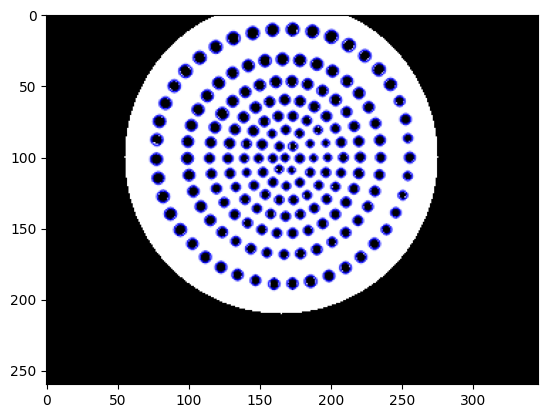

In [4]:
#blob detection
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = False
params.minArea = 10
params.maxArea = 1000
params.filterByCircularity = False
params.minCircularity = 0.1
params.filterByConvexity = False
params.minConvexity = 0.1
params.filterByInertia = False
params.minInertiaRatio = 0.1
params.minDistBetweenBlobs = 1
detector = cv2.SimpleBlobDetector_create(params)

keypoints = detector.detect(thresh)
im_with_keypoints = cv2.drawKeypoints(thresh, keypoints, np.array([]), (0, 0, 255),
                                      cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(im_with_keypoints, cmap='gray')

markers = np.array([k.pt for k in keypoints])
markers_x = markers[:, 0]
markers_y = markers[:, 1]

/home/hussain/miniconda3/envs/tmx/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hussain/miniconda3/envs/tmx/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


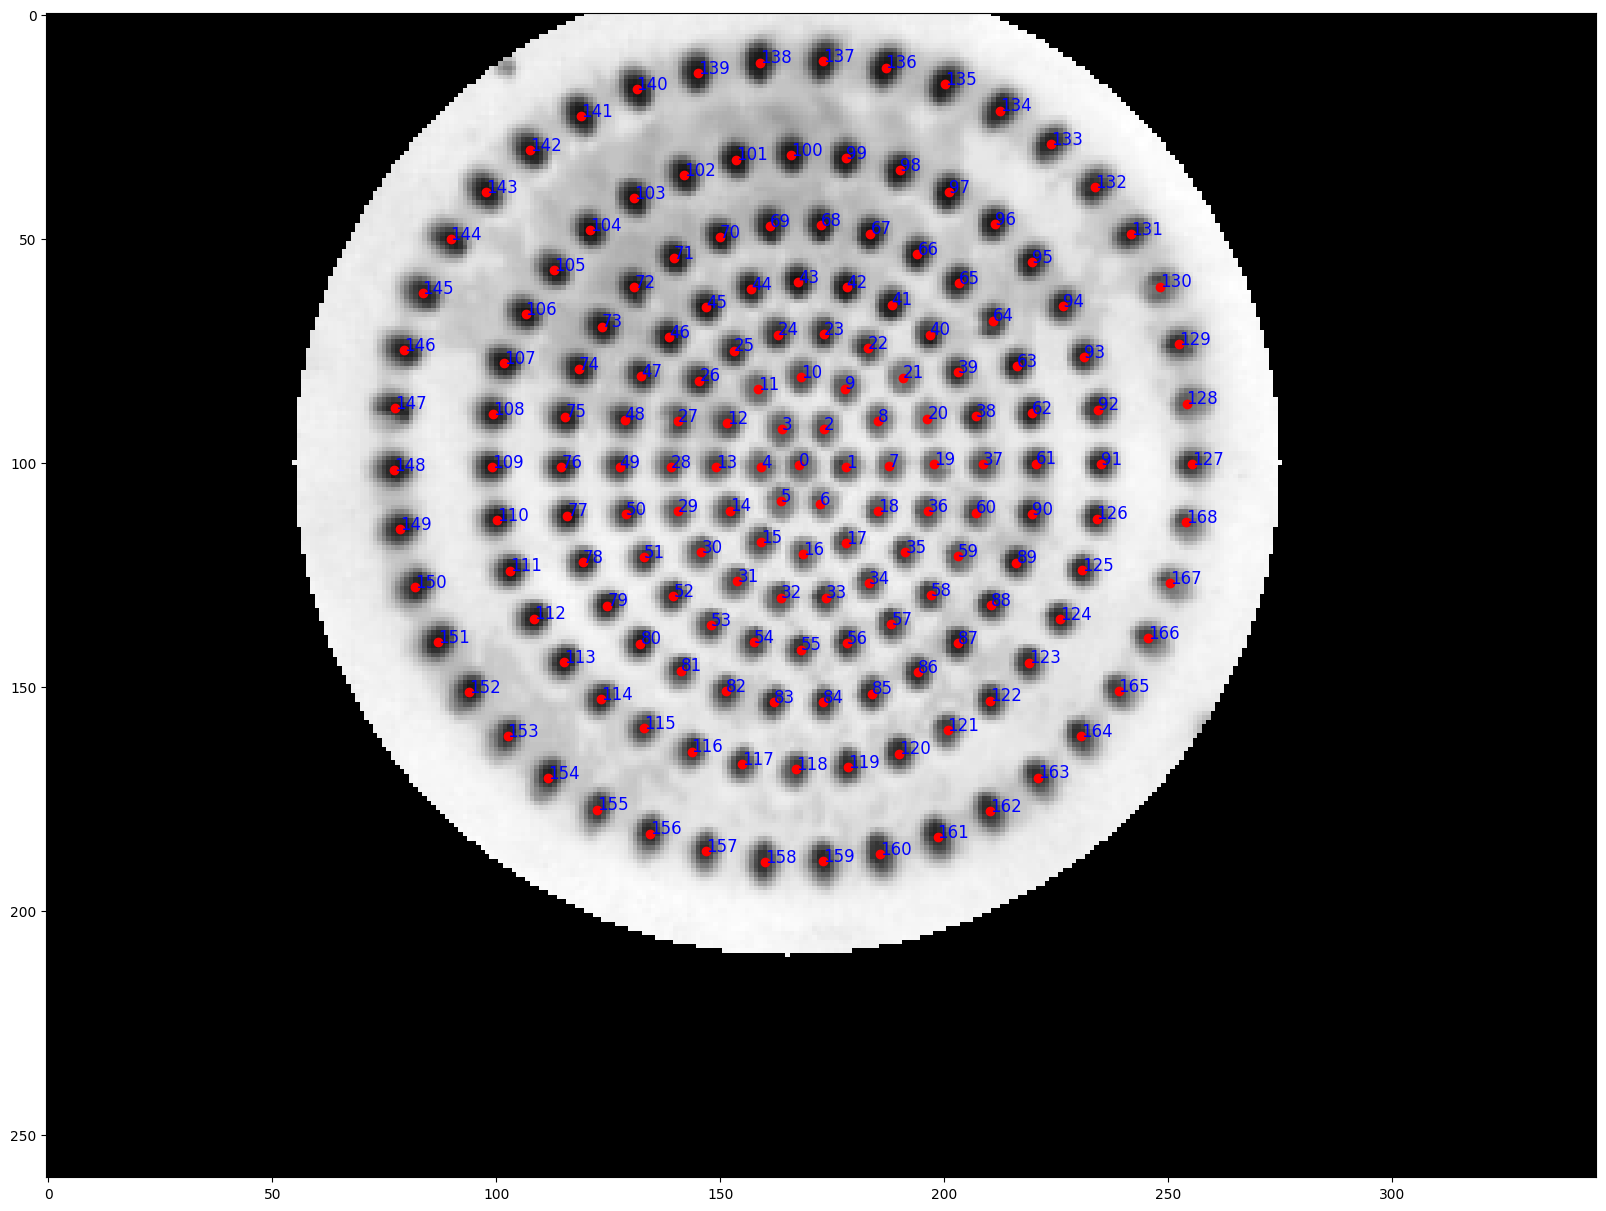

In [5]:
from sort import sort_markers_k_means
sorted_x, sorted_y, layer = sort_markers_k_means(markers_x, markers_y, 7)

#plot markers one by one to check
plt.figure(figsize=(20, 20))
plt.imshow(gray, cmap='gray')
for i in range(len(sorted_x)):
    plt.scatter(sorted_x[i], sorted_y[i], c='r', marker='o')
    plt.text(sorted_x[i], sorted_y[i], str(i), fontsize=12, color='b')


In [6]:
markers_exp = np.stack((sorted_x, sorted_y), axis=1)

markers_exp.shape, markers_T_sensor.shape

((169, 2), (169, 3))

[-0.00242707 -0.00714602  0.07697183 -3.04179252  0.01170368 -0.09027707]


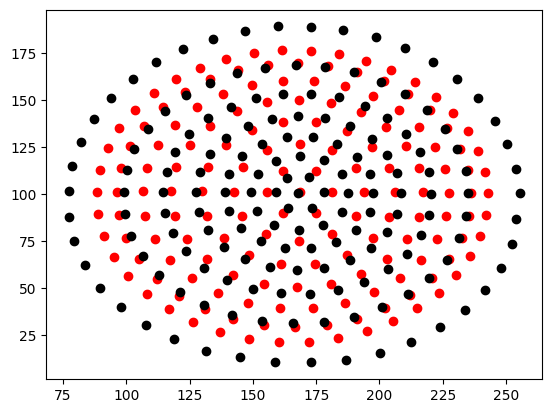

In [7]:
from objective import Cam2Sensor
cam2sensor = Cam2Sensor(camera_matrix, markers_exp, markers_T_sensor)

init_condition = [0, 0, 30, 0, 0., 0] #%x y z rx ry rz

bnds = [(-0.03, 0.03), (-0.03, 0.03), (-0.06, 0.06), (-10, 10), (-10, 10), (-10, 10)]

opt_res = minimize(
    cam2sensor.obj,
    init_condition,
    tol=1e-16
    # bounds=bnds
)

np.set_printoptions(suppress=True)
print(np.array(opt_res.x))

proj_th = cam2sensor.project_markers(opt_res.x, th_markers_arr=markers_T_sensor)
import matplotlib.pyplot as plt

plt.scatter(*proj_th.T, c='r')#, alpha=np.arange(1, 64) / 128 + 1/2)
plt.scatter(*markers_exp.reshape(cam2sensor.num_markers,2).T, c='k')#, alpha=np.arange(1, 64) / 128 + 1/2)
plt.show()


[[-0.00470576]
 [-3.10506219]
 [-0.13893767]] 
 [[ 0.00224231]
 [ 0.00471796]
 [-0.04879708]]


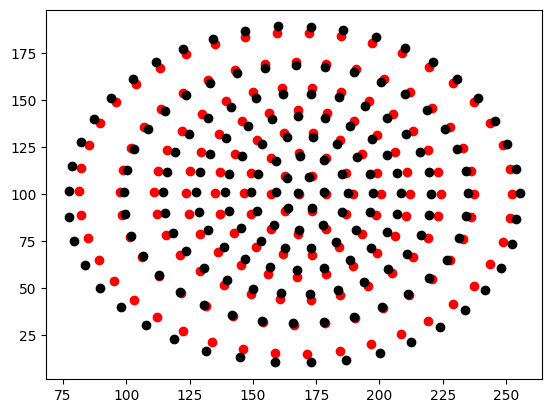

In [8]:
success, rotation_vector, translation_vector = cv2.solvePnP(markers_T_sensor, markers_exp, camera_matrix, dist_coeffs)

print(rotation_vector, '\n', translation_vector)
# project 3D points to image plane
imgpts, jac = cv2.projectPoints(markers_T_sensor, rotation_vector, translation_vector, camera_matrix, dist_coeffs)

imgpts = imgpts.reshape(cam2sensor.num_markers,2)
plt.scatter(*imgpts.T, c='r')#, alpha=np.arange(1, 64) / 128 + 1/2)
plt.scatter(*markers_exp.reshape(cam2sensor.num_markers,2).T, c='k')#, alpha=np.arange(1, 64) / 128 + 1/2)


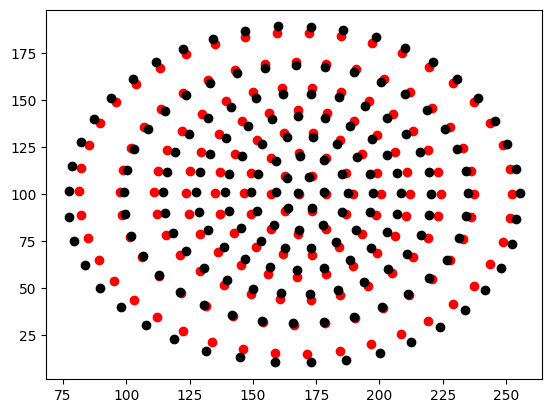

In [9]:

rotation_vector_ = np.array([[-0.00470576],
 [-3.10506219],
 [-0]] )

imgpts, jac = cv2.projectPoints(markers_T_sensor, rotation_vector, translation_vector, camera_matrix, dist_coeffs)

imgpts = imgpts.reshape(cam2sensor.num_markers,2)
plt.scatter(*imgpts.T, c='r')#, alpha=np.arange(1, 64) / 128 + 1/2)
plt.scatter(*markers_exp.reshape(cam2sensor.num_markers,2).T, c='k')#, alpha=np.arange(1, 64) / 128 + 1/2)


In [10]:
R.from_matrix(R.from_euler("xyz", rotation_vector.T).as_matrix()[0].T).as_euler("xyz")

AttributeError: 'list' object has no attribute 'from_matrix'

In [ ]:
from scipy.spatial.transform import Rotation as R

rot_mat = R.from_euler("xyz", rotation_vector.T).as_matrix()
transform_mat = np.eye(4)

transform_mat[:3, :3] = rot_mat
transform_mat[:3, 3] = translation_vector.T

transform_mat

array([[-0.98970294,  0.13865978, -0.03551829,  0.00224231],
       [ 0.1383987 ,  0.99032891,  0.00971836,  0.00471796],
       [ 0.03652234,  0.00470261, -0.99932177, -0.04879708],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [ ]:
transform_mat.T

array([[-0.98970294,  0.1383987 ,  0.03652234,  0.        ],
       [ 0.13865978,  0.99032891,  0.00470261,  0.        ],
       [-0.03551829,  0.00971836, -0.99932177,  0.        ],
       [ 0.00224231,  0.00471796, -0.04879708,  1.        ]])